## Usage

In this notebook, we'll use a Kerchunk index file to speed up the *metadata reading* for a large collection of NetCDF files.

## Kerchunk Background

In the last notebook, we saw that accessing data from the NetCDF file over the network was slow, in part because it was making a bunch of HTTP requests just to read some metadata that's scattered around the NetCDF file. With a Kerchunk index file, you get to bypass all that seeking around for metadata: it's already been extracted into the index file. While that's maybe not a huge deal for a *single* NetCDF file, it matters a bunch when you're dealing with thousands of NetCDF files (2 seconds per file * 1,000 files = ~1 hours *just to read metadata*).

In [1]:
import adlfs
import xarray as xr
import fsspec

In [2]:
%%time
# Note: xarray lazily imports a bunch of stuff. You might want to run this twice
# to get a more accurate timing
m = fsspec.get_mapper(
    "reference://",
    fo="abfs://ciroh/short-range-kerchunk/reference.json",
    remote_options={"account_name": "noaanwm"},
    target_options={"account_name": "noaanwm"},
    skip_instance_cache=True,
)

ds = xr.open_dataset(m, engine="zarr", consolidated=False, chunks={"time": 1})
ds

CPU times: user 2.45 s, sys: 258 ms, total: 2.71 s
Wall time: 2.97 s


<xarray.Dataset>
Dimensions:         (time: 6866, feature_id: 2776738, reference_time: 1)
Coordinates:
  * feature_id      (feature_id) float64 101.0 179.0 181.0 ... 1.18e+09 1.18e+09
  * reference_time  (reference_time) datetime64[ns] 2022-06-29
  * time            (time) datetime64[ns] 2022-06-29T01:00:00 ... 2023-04-21T...
Data variables:
    crs             (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    nudge           (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
    qBtmVertRunoff  (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
    qBucket         (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
    qSfcLatRunoff   (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
    streamflow      (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
    velocity        (time, feature_id) float64 dask.array<chunksize=(1, 2776738), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.6
    NWM_version_number:         v2.2
    TITLE:                      OUTPUT FROM NWM v2.2
    cdm_datatype:               Station
    code_version:               v5.2.0-beta2
    dev:                        dev_ prefix indicates development/internal me...
    ...                         ...
    model_output_type:          channel_rt
    model_output_valid_time:    2022-06-29_01:00:00
    model_total_valid_times:    18
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    station_dimension:          feature_id
    stream_order_output:        1

You'll notice we're using the `zarr` engine for xarray. That's just a convenient way to expose Kerchunk indexed data to anything that can read Zarr (like xarray).

Zarr uses a simple dictionary-like interface with well-known keys. You can get the global attributes at `.zattrs`.

In [3]:
import json

json.loads(m[".zattrs"])

{'Conventions': 'CF-1.6',
 'NWM_version_number': 'v2.2',
 'TITLE': 'OUTPUT FROM NWM v2.2',
 'cdm_datatype': 'Station',
 'code_version': 'v5.2.0-beta2',
 'dev': 'dev_ prefix indicates development/internal meta data',
 'dev_NOAH_TIMESTEP': 3600,
 'dev_OVRTSWCRT': 1,
 'dev_channelBucket_only': 0,
 'dev_channel_only': 0,
 'featureType': 'timeSeries',
 'model_configuration': 'short_range',
 'model_initialization_time': '2022-06-29_00:00:00',
 'model_output_type': 'channel_rt',
 'model_output_valid_time': '2022-06-29_01:00:00',
 'model_total_valid_times': 18,
 'proj4': '+proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=30.0 +lat_2=60.0 +lat_0=40.0 +lon_0=-97.0 +x_0=0 +y_0=0 +k_0=1.0 +nadgrids=@',
 'station_dimension': 'feature_id',
 'stream_order_output': 1}

Or the attributes for a specific array:

In [4]:
json.loads(m["streamflow/.zattrs"])

{'_ARRAY_DIMENSIONS': ['time', 'feature_id'],
 'add_offset': 0.0,
 'coordinates': 'latitude longitude',
 'grid_mapping': 'crs',
 'long_name': 'River Flow',
 'missing_value': -999900,
 'scale_factor': 0.009999999776482582,
 'units': 'm3 s-1',
 'valid_range': [0, 5000000]}

Those attributes are extracted into the Kerchunk index file, and so don't require any (additional) HTTP requests to get. But we *don't* want to exctract the large data variables (we don't want to host the data twice). So what happens when you want to read a data variable? We'll we can look at the `references` attribute to find out.

In [6]:
m.fs.references["streamflow/0.0"]

['abfs://nwm/nwm.20220629/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc',
 614098,
 1860920]

That's saying the data for that `(0, 0)` streamflow chunk can be found at the URL `abfs://nwm/nwm.20220629/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc`, starting at the byte offset `614098`. Thanks to HTTP Range Requests (the same thing that powers streaming video) we can request just the subset of the file we need. When a high-level library like xarray asks for that data, this toolchain (of zarr, fsspec, and adlfs) will make the HTTP range request in the background and deliver the bytes.

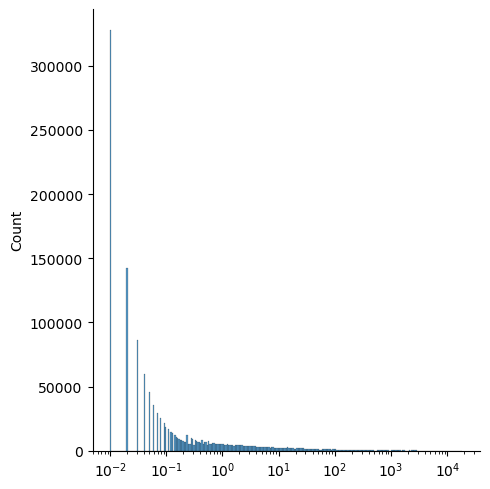

In [11]:
import seaborn as sns


chunk = ds.streamflow.isel(time=0).compute()
sns.displot(chunk[chunk > 0], log_scale=True);

One very important caveat: because Kerchunk is just an index on the existing data, we inherit all of the limitations of its chunking structure.